In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


In [3]:
import torch
import gc
import os

# Memory optimization settings
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
torch.cuda.empty_cache()
gc.collect()

# Check available memory
if torch.cuda.is_available():
    free_mem = torch.cuda.mem_get_info()[0] / 1e9
    total_mem = torch.cuda.mem_get_info()[1] / 1e9
    print(f"GPU Memory: {free_mem:.2f} GB free / {total_mem:.2f} GB total")

    if free_mem < 10:
        print("Low GPU memory - using aggressive optimization")

GPU Memory: 15.72 GB free / 15.83 GB total


In [4]:
# Load Veltri dataset
veltri_train = pd.read_csv('veltri_train.csv')
veltri_val = pd.read_csv('veltri_val.csv')
veltri_test = pd.read_csv('veltri_test.csv')

# Load LMPred dataset
lmpred_train = pd.read_csv('lmpred_train.csv')
lmpred_val = pd.read_csv('lmpred_val.csv')
lmpred_test = pd.read_csv('lmpred_test.csv')

print("=== Dataset Sizes ===")
print(f"Veltri - Train: {len(veltri_train)}, Val: {len(veltri_val)}, Test: {len(veltri_test)}")
print(f"LMPred - Train: {len(lmpred_train)}, Val: {len(lmpred_val)}, Test: {len(lmpred_test)}")

=== Dataset Sizes ===
Veltri - Train: 1424, Val: 708, Test: 1424
LMPred - Train: 3005, Val: 1504, Test: 3007


In [5]:
def prepare_sequence_for_protbert(sequence):
    """
    ProtBERT requires spaces between amino acids
    Example: "ABCDEF" -> "A B C D E F"
    """
    return ' '.join(list(sequence))

# Test the function
sample_seq = veltri_train['sequence'].iloc[0]
print(f"\n=== ProtBERT Sequence Format ===")
print(f"Original: {sample_seq}")
print(f"Formatted: {prepare_sequence_for_protbert(sample_seq)}")


=== ProtBERT Sequence Format ===
Original: QNVMGRGIALPGMANPQMFQRASTDLEEETADVHAEPEQNPQVSKAPQRARGPRGKRLPKAIKE
Formatted: Q N V M G R G I A L P G M A N P Q M F Q R A S T D L E E E T A D V H A E P E Q N P Q V S K A P Q R A R G P R G K R L P K A I K E


In [6]:
class AMPDataset(Dataset):
    """
    PyTorch Dataset for AMP sequences
    """
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.sequences = dataframe['sequence'].values
        self.labels = dataframe['label'].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Get sequence and label
        sequence = self.sequences[idx]
        label = self.labels[idx]

        # Format sequence for ProtBERT (add spaces)
        formatted_seq = prepare_sequence_for_protbert(sequence)

        # Tokenize
        encoding = self.tokenizer(
            formatted_seq,
            add_special_tokens=True,      # Add [CLS] and [SEP]
            max_length=self.max_length,   # Truncate if too long
            padding='max_length',          # Pad if too short
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [7]:
class ProtBERTClassifier(nn.Module):
    """
    ProtBERT + Lightweight Classification Head
    """
    def __init__(self, n_classes=2, dropout=0.3, freeze_bert=False):
        super(ProtBERTClassifier, self).__init__()

        # Load pre-trained ProtBERT
        self.bert = BertModel.from_pretrained("Rostlab/prot_bert")

        # Freeze BERT parameters if specified
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(1024, n_classes)  # Direct: 1024 → 2

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Dropout + classify
        x = self.dropout(cls_embedding)
        logits = self.classifier(x)

        return logits

In [8]:
def train_epoch(model, dataloader, optimizer, criterion, device, scaler):
    """
    Train for one epoch with mixed precision (FP16)
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Track metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        # Clear cache every 5 batches
        if len(all_preds) % 5 == 0:
            torch.cuda.empty_cache()

        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """
    Evaluate model on validation/test set
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask)

            # Calculate loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Get predictions and probabilities
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (AMP)

    avg_loss = total_loss / len(dataloader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

    return metrics

In [14]:
def train_protbert_model(train_df, val_df, test_df, dataset_name,
                         batch_size=4, epochs=5, learning_rate=2e-5,
                         freeze_bert=False, use_scheduler=True):

    print(f"\n{'='*60}")
    print(f"Training ProtBERT Model: {dataset_name}")
    print(f"{'='*60}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Freeze BERT: {freeze_bert}")

    # Clear memory
    torch.cuda.empty_cache()
    gc.collect()

    # Load tokenizer
    print("\nLoading ProtBERT tokenizer...")
    tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

    # Create datasets
    print("Creating datasets...")
    train_dataset = AMPDataset(train_df, tokenizer, max_length=256)  # ✨ Reduced from 512
    val_dataset = AMPDataset(val_df, tokenizer, max_length=256)
    test_dataset = AMPDataset(test_df, tokenizer, max_length=256)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    print("\nInitializing ProtBERT model...")
    model = ProtBERTClassifier(n_classes=2, dropout=0.3, freeze_bert=freeze_bert)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    scheduler = None
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=2
        )

    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler()

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    best_val_f1 = 0
    best_model_state = None
    patience = 3
    patience_counter = 0

    # Training loop
    print("\nStarting training...")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-" * 60)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, scaler)

        # Validate
        val_metrics = evaluate(model, val_loader, criterion, device)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])

        # Print metrics
        print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
        print(f"Val F1: {val_metrics['f1']:.4f}, Val AUC: {val_metrics['auc']:.4f}")

        # Update learning rate (if scheduler exists)
        if scheduler is not None:
            scheduler.step(val_metrics['f1'])
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.2e}")

        # Save best model
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_model_state = model.state_dict().copy()
            patience_counter = 0  # ← RESET COUNTER
            print(f"✓ New best model! (F1: {best_val_f1:.4f})")
        else:  # ← ADD ELSE BLOCK
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s)")
            if patience_counter >= patience:
                print(f"\n Early stopping! No improvement for {patience} epochs.")
                break

        # Clear cache after each epoch
        torch.cuda.empty_cache()

    # Load best model
    print("\nLoading best model for testing...")
    model.load_state_dict(best_model_state)

    # Test
    print("\nEvaluating on test set...")
    test_metrics = evaluate(model, test_loader, criterion, device)

    print(f"\n{'='*60}")
    print("TEST RESULTS")
    print(f"{'='*60}")
    for metric, value in test_metrics.items():
        print(f"{metric.capitalize():15s}: {value:.4f}")

    return model, history, test_metrics


# Helper function to plot training history
def plot_training_history(history, dataset_name):
    """
    Plot training curves
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{dataset_name} - Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Accuracy & F1
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[1].plot(epochs, history['val_f1'], 'g-', label='Val F1')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title(f'{dataset_name} - Metrics')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'protbert_{dataset_name.lower()}_training.png', dpi=300, bbox_inches='tight')
    plt.show()


TRAINING ON VELTRI DATASET (NO SCHEDULER)

Training ProtBERT Model: Veltri
Batch size: 2
Epochs: 5
Learning rate: 2e-05
Freeze BERT: False

Loading ProtBERT tokenizer...
Creating datasets...

Initializing ProtBERT model...


Loading weights:   0%|          | 0/487 [00:00<?, ?it/s]

BertModel LOAD REPORT from: Rostlab/prot_bert
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Starting training...

Epoch 1/5
------------------------------------------------------------


Training:   0%|          | 0/712 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/354 [00:00<?, ?it/s]


Train Loss: 0.5266, Train Acc: 0.8329
Val Loss: 0.2821, Val Acc: 0.9294
Val F1: 0.9284, Val AUC: 0.9459
Current LR: 2.00e-05
✓ New best model! (F1: 0.9284)

Epoch 2/5
------------------------------------------------------------


Training:   0%|          | 0/712 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/354 [00:00<?, ?it/s]


Train Loss: 0.4757, Train Acc: 0.8525
Val Loss: 0.6670, Val Acc: 0.5014
Val F1: 0.6673, Val AUC: 0.6744
Current LR: 2.00e-05
No improvement for 1 epoch(s)

Epoch 3/5
------------------------------------------------------------


Training:   0%|          | 0/712 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/354 [00:00<?, ?it/s]


Train Loss: 0.4524, Train Acc: 0.8371
Val Loss: 0.2483, Val Acc: 0.9421
Val F1: 0.9394, Val AUC: 0.9573
Current LR: 2.00e-05
✓ New best model! (F1: 0.9394)

Epoch 4/5
------------------------------------------------------------


Training:   0%|          | 0/712 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/354 [00:00<?, ?it/s]


Train Loss: 0.5228, Train Acc: 0.8230
Val Loss: 0.5902, Val Acc: 0.7458
Val F1: 0.7955, Val AUC: 0.8291
Current LR: 2.00e-05
No improvement for 1 epoch(s)

Epoch 5/5
------------------------------------------------------------


Training:   0%|          | 0/712 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/354 [00:00<?, ?it/s]


Train Loss: 0.5763, Train Acc: 0.8111
Val Loss: 0.4953, Val Acc: 0.8785
Val F1: 0.8746, Val AUC: 0.9408
Current LR: 2.00e-05
No improvement for 2 epoch(s)

Loading best model for testing...

Evaluating on test set...


Evaluating:   0%|          | 0/712 [00:00<?, ?it/s]


TEST RESULTS
Loss           : 0.5645
Accuracy       : 0.8596
Precision      : 0.8926
Recall         : 0.8174
F1             : 0.8534
Auc            : 0.9212
Sensitivity    : 0.8174
Specificity    : 0.9017


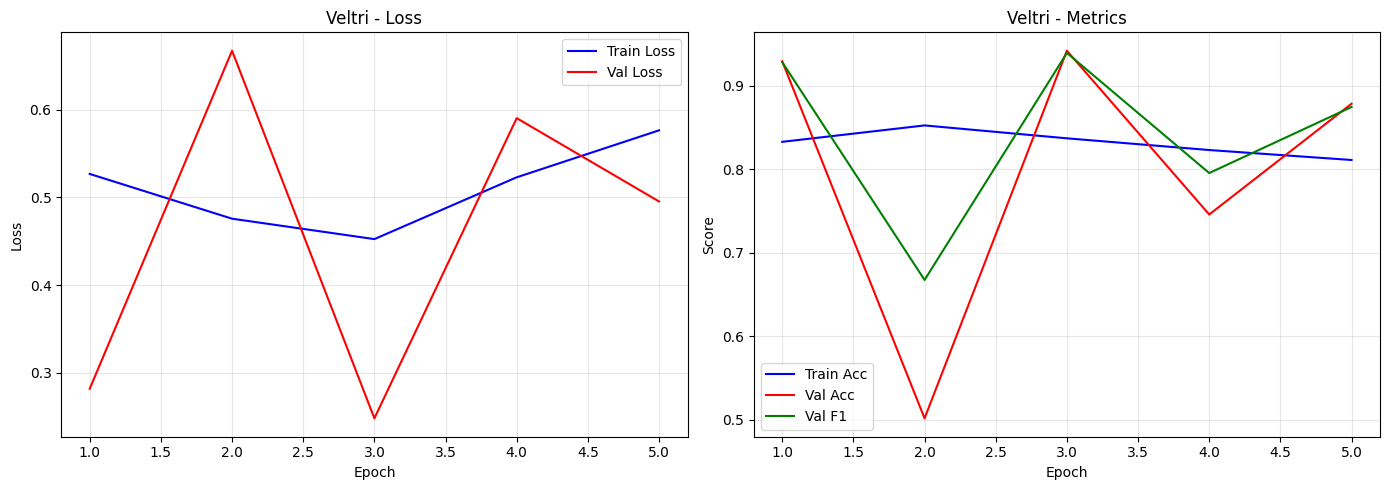

In [15]:
# Veltri
print("\n" + "="*80)
print("TRAINING ON VELTRI DATASET (NO SCHEDULER)")
print("="*80)

veltri_model, veltri_history, veltri_results = train_protbert_model(
    veltri_train,
    veltri_val,
    veltri_test,
    dataset_name="Veltri",
    batch_size=2,
    epochs=5,
    learning_rate=2e-5,
    freeze_bert=False,
    use_scheduler=False
)

plot_training_history(veltri_history, "Veltri")
torch.save(veltri_model.state_dict(), 'protbert_veltri_final.pth')

TRAINING ON LMPRED DATASET

Training ProtBERT Model: LMPred
Batch size: 2
Epochs: 5
Learning rate: 1e-05
Freeze BERT: False

Loading ProtBERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Creating datasets...

Initializing ProtBERT model...


config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/487 [00:00<?, ?it/s]

BertModel LOAD REPORT from: Rostlab/prot_bert
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Starting training...

Epoch 1/5
------------------------------------------------------------


Training:   0%|          | 0/1503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/752 [00:00<?, ?it/s]


Train Loss: 0.5752, Train Acc: 0.8103
Val Loss: 0.6259, Val Acc: 0.8444
Val F1: 0.8541, Val AUC: 0.9082
Current LR: 1.00e-05
✓ New best model! (F1: 0.8541)

Epoch 2/5
------------------------------------------------------------


Training:   0%|          | 0/1503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/752 [00:00<?, ?it/s]


Train Loss: 0.4823, Train Acc: 0.8799
Val Loss: 0.5186, Val Acc: 0.8743
Val F1: 0.8687, Val AUC: 0.8993
Current LR: 1.00e-05
✓ New best model! (F1: 0.8687)

Epoch 3/5
------------------------------------------------------------


Training:   0%|          | 0/1503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/752 [00:00<?, ?it/s]


Train Loss: 0.4356, Train Acc: 0.8922
Val Loss: 0.8361, Val Acc: 0.7812
Val F1: 0.8151, Val AUC: 0.8213
Current LR: 1.00e-05

Epoch 4/5
------------------------------------------------------------


Training:   0%|          | 0/1503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/752 [00:00<?, ?it/s]


Train Loss: 0.4689, Train Acc: 0.8652
Val Loss: 0.5861, Val Acc: 0.8637
Val F1: 0.8718, Val AUC: 0.8841
Current LR: 1.00e-05
✓ New best model! (F1: 0.8718)

Epoch 5/5
------------------------------------------------------------


Training:   0%|          | 0/1503 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/752 [00:00<?, ?it/s]


Train Loss: 0.4361, Train Acc: 0.8852
Val Loss: 0.5383, Val Acc: 0.8763
Val F1: 0.8812, Val AUC: 0.9308
Current LR: 1.00e-05
✓ New best model! (F1: 0.8812)

Loading best model for testing...

Evaluating on test set...


Evaluating:   0%|          | 0/1504 [00:00<?, ?it/s]


TEST RESULTS
Loss           : 0.5691
Accuracy       : 0.8686
Precision      : 0.8497
Recall         : 0.8955
F1             : 0.8720
Auc            : 0.9306
Sensitivity    : 0.8955
Specificity    : 0.8418


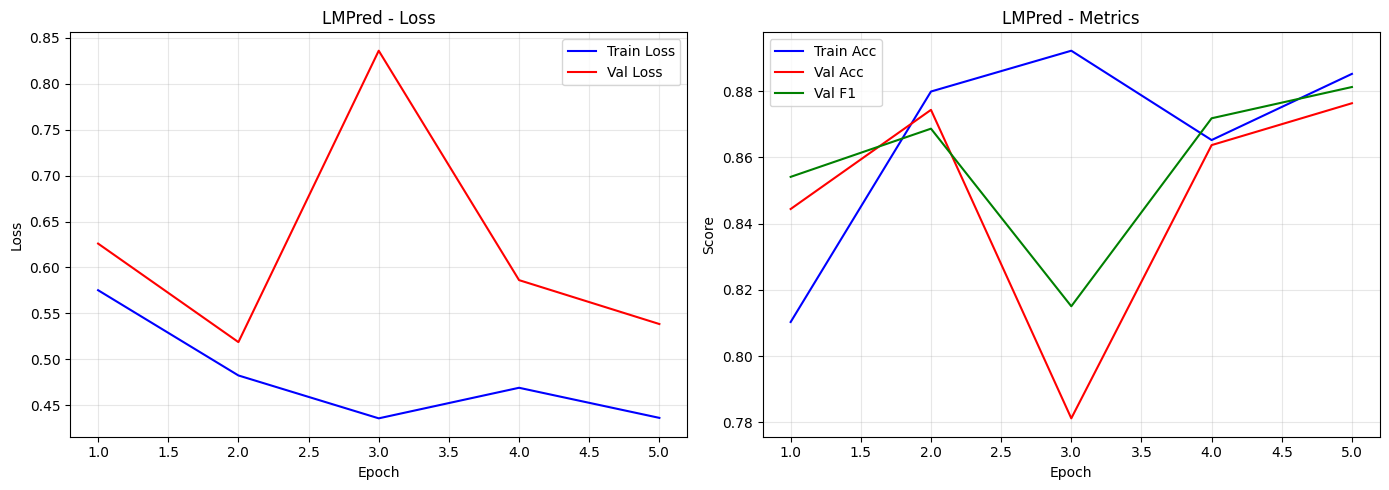


Model saved to 'protbert_lmpred_model.pth'


In [10]:
# LMPredprint("\n" + "="*80)
print("TRAINING ON LMPRED DATASET")
print("="*80)

lmpred_model, lmpred_history, lmpred_results = train_protbert_model(
    lmpred_train,
    lmpred_val,
    lmpred_test,
    dataset_name="LMPred",
    batch_size=2,
    epochs=5,
    learning_rate=1e-5,
    freeze_bert=False
)

plot_training_history(lmpred_history, "LMPred")

# Save model
torch.save(lmpred_model.state_dict(), 'protbert_lmpred_model.pth')
print("\nModel saved to 'protbert_lmpred_model.pth'")


COMPARISON: Baseline vs ProtBERT
            Model Dataset  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Test_AUC
Baseline-LR (k=3)  Veltri       0.827949        0.822069     0.837079 0.829506  0.906779
Baseline-LR (k=3)  LMPred       0.749917        0.741479     0.767132 0.754088  0.814845
         ProtBERT  Veltri       0.859551        0.892638     0.817416 0.853372  0.921190
         ProtBERT  LMPred       0.868640        0.849747     0.895542 0.872044  0.930630


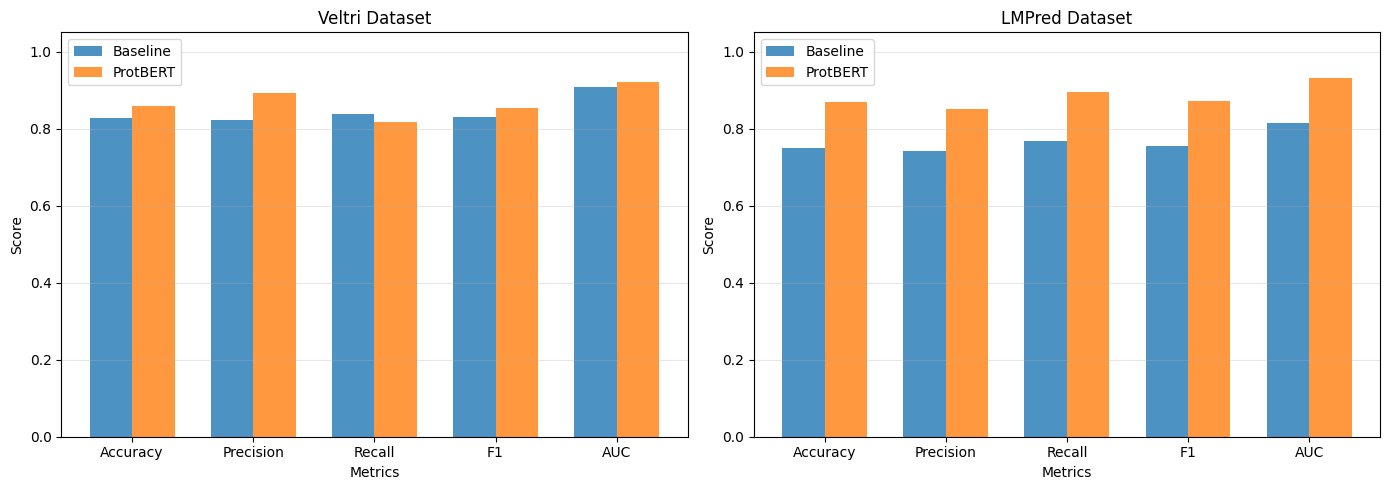

In [16]:
# Load baseline results
baseline_results = pd.read_csv('baseline_results.csv')

# Create ProtBERT results
protbert_results_df = pd.DataFrame({
    'Model': ['ProtBERT'] * 2,
    'Dataset': ['Veltri', 'LMPred'],
    'Test_Accuracy': [veltri_results['accuracy'], lmpred_results['accuracy']],
    'Test_Precision': [veltri_results['precision'], lmpred_results['precision']],
    'Test_Recall': [veltri_results['recall'], lmpred_results['recall']],
    'Test_F1': [veltri_results['f1'], lmpred_results['f1']],
    'Test_AUC': [veltri_results['auc'], lmpred_results['auc']]
})

# Combine results
all_results = pd.concat([baseline_results, protbert_results_df], ignore_index=True)

print("\n" + "="*80)
print("COMPARISON: Baseline vs ProtBERT")
print("="*80)
print(all_results.to_string(index=False))

# Save combined results
all_results.to_csv('results_baseline_protbert.csv', index=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, dataset in enumerate(['Veltri', 'LMPred']):
    data = all_results[all_results['Dataset'] == dataset]

    metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

    x = np.arange(len(metrics))
    width = 0.35

    baseline_scores = data[data['Model'] == 'Baseline-LR (k=3)'][metrics].values[0]
    protbert_scores = data[data['Model'] == 'ProtBERT'][metrics].values[0]

    axes[idx].bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.8)
    axes[idx].bar(x + width/2, protbert_scores, width, label='ProtBERT', alpha=0.8)

    axes[idx].set_xlabel('Metrics')
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(f'{dataset} Dataset')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(metric_labels)
    axes[idx].legend()
    axes[idx].set_ylim([0, 1.05])
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_vs_protbert.png', dpi=300, bbox_inches='tight')
plt.show()